# Final Project

Mingtao Gao

For problem set 3, I run the logistic regression model on our processed Enron dataset and Ishan run the decision tree classifier. We evaluate each model's performance based on accuracy, precision, and recall. For our final project, we plan to build total six predictive machine learning models and compare the results to analyze which model performs the best and why. In this notebook, I will run Naive Bayes classifier and SVM classifier. The process can be summarized in the following steps:
1. Use SelectKBest to select and reduce features
2. Use GridSearchCV to determine optimum classifer parameters for the classifiers (if needed)
3. Run the classifiers
4. Evaluate their performances (return to Step 1 if Precision and Recall threshold (0.3) not reached)

In [1]:
import re
import os
import pprint
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

import sklearn
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

#### Processed Enron Dataset from Last week 

In [2]:
df = pd.read_csv('enron_processed.csv', index_col = 0)
print(df.shape)
df.head()

(144, 26)


,poi,salary,bonus,long_term_incentive,deferred_income,deferral_payments,loan_advances,other,expenses,director_fees,...,from_all,to_all,from_insider,to_insider,from_poi,to_poi,from_poi_ratio,to_poi_ratio,from_poi_ratio_2,to_poi_ratio_2
insider,,,,,,,,,,,,,,,,,,,,,
"BELDEN, TIMOTHY N",True,213999.0,5249999.0,0.0,-2334434.0,2144013.0,0.0,210698.0,17355.0,0.0,...,226,382,105,14,3,0,0.013274,0.000000,0.028571,0.000000
"BOWEN JR, RAYMOND M",True,278601.0,1350000.0,974293.0,-833.0,0.0,0.0,1621.0,65907.0,0.0,...,25,17,17,0,6,0,0.240000,0.000000,0.352941,0.438452
"CALGER, CHRISTOPHER F",True,240189.0,1250000.0,375304.0,-262500.0,0.0,0.0,486.0,35818.0,0.0,...,110,102,39,24,20,2,0.181818,0.019608,0.512821,0.083333
"CAUSEY, RICHARD A",True,415189.0,1000000.0,350000.0,-235000.0,0.0,0.0,307895.0,30674.0,0.0,...,70,37,49,0,3,0,0.042857,0.000000,0.061224,0.438452
"COLWELL, WESLEY",True,288542.0,1200000.0,0.0,-144062.0,27610.0,0.0,101740.0,16514.0,0.0,...,64,18,42,2,20,0,0.312500,0.000000,0.476190,0.000000


In [3]:
scaled_df = df.copy()
scaled_df.iloc[:, 1:] = scale(scaled_df.iloc[:, 1:])
cols = scaled_df.columns.tolist()
my_dataset = scaled_df.to_dict(orient='index')

#### Helper Functions

In [4]:
# Seperate target feature and other features as two lists
def separateLabels(dataset, cols):
    labels = []
    features = []    
    for key in my_dataset.keys():
        lst = [my_dataset[key][col] for col in cols]
        labels.append(lst[0])
        features.append(np.array(lst[1:]))
    return features, labels

In [5]:
# Split the dataset into training data and testing data
def trainTestSplit(df, holdBackFraction = .2):
    df = df.reindex(np.random.permutation(df.index))
    holdBackIndex = int(holdBackFraction * len(df))
    train_data = df[holdBackIndex:].copy()
    test_data = df[:holdBackIndex].copy()
    return train_data, test_data

In [6]:
# Function used to tune the algorithm using grid search 
# and prints out the average evaluation metrics results (accuracy, percision, recall)
def tune_params(grid_search, features, labels, params, iters=50):
    acc = []
    pre = []
    recall = []
    
    for i in range(iters):
        features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size = 0.20, random_state = i)
        grid_search.fit(features_train, labels_train)
        predicts = grid_search.predict(features_test)
        
        acc = acc + [accuracy_score(labels_test, predicts)] 
        pre = pre + [precision_score(labels_test, predicts)]
        recall = recall + [recall_score(labels_test, predicts)]
    
    print ("accuracy: {}".format(np.mean(acc)))
    print ("precision: {}".format(np.mean(pre)))
    print ("recall: {}".format(np.mean(recall)))

    best_params = grid_search.best_estimator_.get_params()
    for param_name in params.keys():
        print("%s = %r, " % (param_name, best_params[param_name]))

In [7]:
# Select the best k features
def feature_selection(nb_features,features, labels):
    selector = SelectKBest(f_classif, k=nb_features)
    selector.fit(features, labels)
    return selector

In [8]:
# Cross-validation and calculate precision and recall metrics
def test_classifier(clf, labels, features, nb_features, folds = 1000):
    cv = StratifiedShuffleSplit(folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    precision=0
    recall=0
    f1=0
    f2=0
    for train_idx, test_idx in cv.split(features, labels): 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
            
        #Selection of the best K features   
        selector=feature_selection(nb_features,features_train, labels_train)
        features_train_transformed = selector.transform(features_train)
        features_test_transformed  = selector.transform(features_test)   
            
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train_transformed, labels_train)
        predictions = clf.predict(features_test_transformed)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                break
   
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
    except:
        None
    return precision,recall,f1,f2

In [9]:
# Plot confusion matrix
def plotConfusionMatrix(clf, testDF, target, feature=None):
    if feature:
        predictions = clf.predict(np.stack(testDF[feature], axis=0))
    else:
        predictions = clf.predict(testDF.drop([target], axis=1))
    mat = sklearn.metrics.confusion_matrix(testDF[target], predictions)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                    xticklabels=testDF[target].unique(), yticklabels=testDF[target].unique())
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.title("Confusion Matrix")
    plt.show()
    plt.close()

In [10]:
# Plot ROC
def plotMultiROC(clf, testDF, target, feature=None):
    classes = clf.classes_
    
    if feature:
        probs = clf.predict_proba(np.stack(testDF[feature], axis=0))
        predictions = clf.predict(np.stack(testDF[feature], axis=0))
    else:
        probs = clf.predict_proba(testDF.drop([target], axis=1))
        predictions = clf.predict(testDF.drop([target], axis=1))
    
    fig, ax = plt.subplots(figsize = (10,10))

    aucVals = []
    for classIndex, className in enumerate(classes): 
        truths = [1 if c == className else 0 for c in testDF[target]]
        predict = [1 if c == className else 0 for c in predictions]
        scores = probs[:, classIndex]

        #Get the ROC curve
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(truths, scores)
        auc = sklearn.metrics.auc(fpr, tpr)
        aucVals.append(auc)

        #Plot the class's line
        ax.plot(fpr, tpr, label = "{} (AUC ${:.3f}$)".format(str(className).split(':')[0], auc))

    #Make the plot nice, then display it
    ax.set_title('Receiver Operating Characteristics')
    plt.plot([0,1], [0,1], color = 'k', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc = 'lower right')
    plt.show()
    plt.close()

In [11]:
features, labels = separateLabels(my_dataset, cols)

### Naive Bayes

A Naive Bayes classifier is a probabilistic machine learning model, based on the Bayes theorem, that’s used for classification task. The Bayes theorem finds the probability of A happening, given that B has occurred. In this case, known the finantial and email features of insiders, the classifier is trying to predict whether the insider is a POI based on probabilities.

#### Select the best features

Bernoulli Naive Bayes is a variant of Naive Bayes, which is used for discrete data, where features are only in binary form. In this case, our target is 'poi', a binary variable. Because for this algorithm, there is no specific parameter to tune, we will skip step 2 and run the model with selected features.

In [12]:
nb_features_orig = len(features[1])
precision_result = []
recall_result = []
f1_result = []
f2_result = []
nb_feature_store = []

clf=BernoulliNB()

# Calculate the evaluation metrics for k best number of features selected in the model
for nb_features in range(1,nb_features_orig):
    precision, recall, f1, f2 = test_classifier(clf, labels, features, nb_features, folds=1000)              
    precision_result.append(precision)
    recall_result.append(recall)     
    f1_result.append(f1)
    f2_result.append(f2)
    nb_feature_store.append(nb_features)

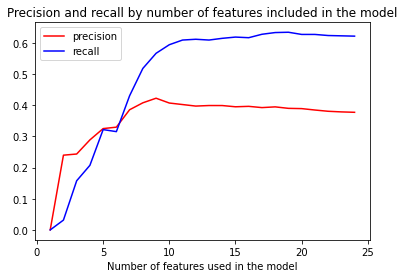

In [13]:
# Plot precision and recall by different number of features used in the model
plt.plot(range(1,nb_features_orig),precision_result,c='red',label='precision')
plt.plot(range(1,nb_features_orig),recall_result,c='blue',label='recall')
plt.xlabel("Number of features used in the model")
plt.title("Precision and recall by number of features included in the model")
plt.legend()
plt.show()

From the plot, we can see the precision and recall of this classifier stay the same with more than 10 features. Therefore, I choose 10 as the number of features to be selected for Naive Bayes model.

In [14]:
print ("Precsion when the 10 best features are selected:", precision_result[9])
print ("Recall when the 10 best features are selected", recall_result[9])

Precsion when the 10 best features are selected: 0.4066461116820829
Recall when the 10 best features are selected 0.5935


In [15]:
result=pd.DataFrame([nb_feature_store,precision_result,recall_result,f1_result,f2_result]).T
result.columns=['nb_feature','precision','recall','f1','f2']
result.head()

,nb_feature,precision,recall,f1,f2
0,1.0,0.000000,0.0000,0.000000,0.000000
1,2.0,0.239544,0.0315,0.055678,0.038122
2,3.0,0.243243,0.1575,0.191199,0.169446
3,4.0,0.288502,0.2070,0.241048,0.219396
4,5.0,0.324747,0.3215,0.323116,0.322144


In [16]:
selector = feature_selection(11, features, labels)
feature_importance=pd.DataFrame([cols[1:], list(selector.scores_)]).T
feature_importance.columns=['feature_name','score']
feature_importance.sort_values('score', ascending=False, inplace=True)
feature_importance[:10]

,feature_name,score
13,total_stock_value,24.3079
0,salary,24.0495
10,stock_op_exercised,22.6105
1,bonus,21.7933
3,deferred_income,16.3867
19,from_poi,16.057
24,to_poi_ratio_2,14.9646
23,from_poi_ratio_2,13.6494
14,bonus_salary_ratio,11.0464
2,long_term_incentive,10.867


Based on feature importance scores, the top 10 features selected are 1) total_stock_value, 2) salary, 3) stock_op_exercised, 4) bonus, 5) deferred_income, 6) from_poi, 7) to_poi_ratio_2, 8) from_poi_ratio_2, 9) bonus_salary_ratio, 10) long_term_incentives.

In [17]:
final_features = ['poi'] + feature_importance.feature_name.tolist()[:10]
features_list = scaled_df[final_features].reset_index().drop('insider', axis=1)
print(features_list.shape)
features_list.head()

(144, 11)


,poi,total_stock_value,salary,stock_op_exercised,bonus,deferred_income,from_poi,to_poi_ratio_2,from_poi_ratio_2,bonus_salary_ratio,long_term_incentive
0,True,-0.292161,0.196501,-0.247013,3.744850,-3.987831,0.122450,-0.942030,-0.475642,6.033673,-0.481190
1,True,-0.431129,0.549894,-0.441284,0.561489,0.313693,0.621489,0.816922,2.293639,0.729556,0.958107
2,True,-0.451526,0.339768,-0.441284,0.479865,-0.168638,2.950341,-0.607719,3.658596,0.826169,0.073236
3,True,-0.066975,1.297075,-0.441284,0.275803,-0.117947,0.122450,0.816922,-0.196869,0.072953,0.035856
4,True,-0.358916,0.604275,-0.441284,0.439052,0.049679,2.950341,-0.942030,3.345870,0.544519,-0.481190


#### Run and Evaluation

In [18]:
train_df, test_df = trainTestSplit(features_list)

In [19]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(train_df.drop(['poi'], axis=1), train_df['poi'])

BernoulliNB()

In [20]:
print("Training:")
print(naiveBayes.score(train_df.drop(['poi'], axis=1), train_df['poi']))
print("Testing:")
print(naiveBayes.score(test_df.drop(['poi'], axis=1), test_df['poi']))

Training:
0.8448275862068966
Testing:
0.9285714285714286


In [21]:
predictions = naiveBayes.predict(test_df.drop(['poi'], axis=1))

In [22]:
print('Accuracy:')
print(sklearn.metrics.accuracy_score(test_df['poi'], predictions))
print('Precision:')
print(sklearn.metrics.precision_score(test_df['poi'], predictions))
print('Recall:')
print(sklearn.metrics.recall_score(test_df['poi'], predictions))
print('F-measures:')
print(sklearn.metrics.f1_score(test_df['poi'], predictions))

Accuracy:
0.9285714285714286
Precision:
1.0
Recall:
0.5
F-measures:
0.6666666666666666


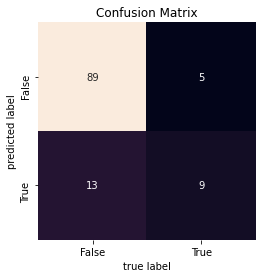

In [23]:
plotConfusionMatrix(naiveBayes, train_df, 'poi')

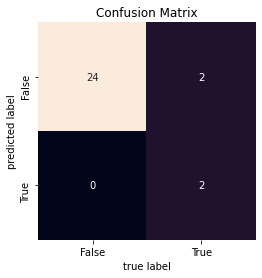

In [24]:
plotConfusionMatrix(naiveBayes, test_df, 'poi')

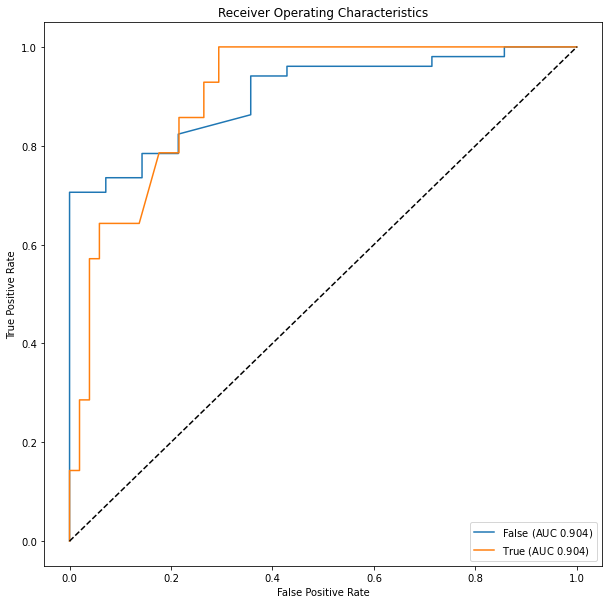

In [25]:
plotMultiROC(naiveBayes, train_df, 'poi')

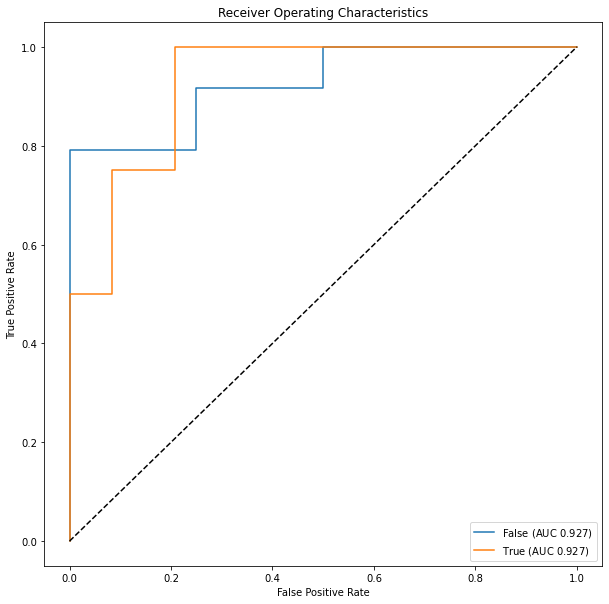

In [26]:
plotMultiROC(naiveBayes, test_df, 'poi')

### SVM

A Support Vector Machine (SVM) is a supervised machine learning algorithm that can be employed for classification problems. Its advantage in this case is that SVM works well on smaller cleaner datasets. 

#### Select the best features

In [27]:
selector = SelectKBest(f_classif, k=10).fit(features, labels)
scores = zip(cols[1:], selector.scores_)
sorted_scores = sorted(scores, key=lambda x: x[1], reverse = True)

print ('Features selected:')
features_selected=[cols[i+1] for i in selector.get_support(indices=True)]
pprint.pprint(features_selected)

Features selected:
['salary',
 'bonus',
 'long_term_incentive',
 'deferred_income',
 'stock_op_exercised',
 'total_stock_value',
 'bonus_salary_ratio',
 'from_poi',
 'from_poi_ratio_2',
 'to_poi_ratio_2']


In [28]:
feature_importance.feature_name.tolist()[:10]

['total_stock_value',
 'salary',
 'stock_op_exercised',
 'bonus',
 'deferred_income',
 'from_poi',
 'to_poi_ratio_2',
 'from_poi_ratio_2',
 'bonus_salary_ratio',
 'long_term_incentive']

By comparing the top 10 features selected by selectKBest method and the top 10 features selected for Naive Bayes classifier, we found that although the top 10 feature in each case received different importance scores and thus different rankings, the features in two top 10 lists are the same. Therefore, we will keep use these features for SVM classifier: salary, bonus, long_term_incentive, deferred_income, stock_op_exercised, total_stock_value, bonus_salary_ratio, from_poi, from_poi_ratio_2, to_poi_ratio_2. 

#### Run and Evaluation

In [29]:
# GridSearchCV to find the best parameters
features, labels = separateLabels(my_dataset, final_features)
svm_clf = svm.SVC()
svm_param = {'kernel':('linear', 'rbf', 'sigmoid', 'poly'),
             'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
             'C': [0.1, 1, 10, 100, 1000]}
svm_grid_search = GridSearchCV(estimator = svm_clf, param_grid = svm_param)

print("SVM model evaluation")
tune_params(svm_grid_search, features, labels, svm_param)

SVM model evaluation
accuracy: 0.8510344827586206
precision: 0.1716666666666667
recall: 0.14966666666666667
kernel = 'sigmoid', 
gamma = 1, 
C = 1, 


In [30]:
# Fit the model with tuned parameters
svm = svm_grid_search.fit(train_df.drop(['poi'], axis=1), train_df['poi'])

In [31]:
print("Training:")
print(svm.score(train_df.drop(['poi'], axis=1), train_df['poi']))
print("Testing:")
print(svm.score(test_df.drop(['poi'], axis=1), test_df['poi']))

Training:
0.9655172413793104
Testing:
0.8928571428571429


In [32]:
predictions = svm.predict(test_df.drop(['poi'], axis=1))

In [33]:
print('Accuracy:')
print(sklearn.metrics.accuracy_score(test_df['poi'], predictions))
print('Precision:')
print(sklearn.metrics.precision_score(test_df['poi'], predictions))
print('Recall:')
print(sklearn.metrics.recall_score(test_df['poi'], predictions))
print('F-measures:')
print(sklearn.metrics.f1_score(test_df['poi'], predictions))

Accuracy:
0.8928571428571429
Precision:
0.6
Recall:
0.75
F-measures:
0.6666666666666665


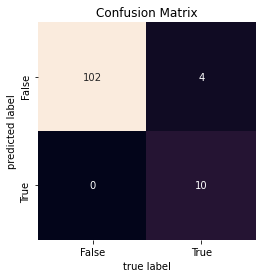

In [34]:
plotConfusionMatrix(svm, train_df, 'poi')

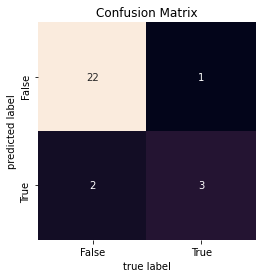

In [35]:
plotConfusionMatrix(svm, test_df, 'poi')

### Logistic Regression with PCA

In [56]:
# Implement PCA
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(features)
scaled_df['pca'] = [r for r in reduced_data]
scaled_df['pca_reduced_10'] = scaled_df['pca'].apply(lambda x: x[:10])

In [57]:
train_df, test_df = trainTestSplit(scaled_df)

In [58]:
# Fit a logistic regression
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_df['pca_reduced_10'], axis=0), train_df['poi'])

print("Training: ")
print(logistic.score(np.stack(train_df['pca_reduced_10'], axis=0), train_df['poi']))
print("Testing: ")
print(logistic.score(np.stack(test_df['pca_reduced_10'], axis=0), test_df['poi']))

Training: 
0.9224137931034483
Testing: 
0.9285714285714286


In [59]:
# More evaluations on predictions
test_df['logistic_predict'] = logistic.predict(np.stack(test_df['pca_reduced_10'], axis=0))

print('Accuracy:')
print(sklearn.metrics.accuracy_score(test_df['poi'], test_df['logistic_predict']))
print('Precision:')
print(sklearn.metrics.precision_score(test_df['poi'], test_df['logistic_predict']))
print('Recall:')
print(sklearn.metrics.recall_score(test_df['poi'], test_df['logistic_predict']))
print('F-measures:')
print(sklearn.metrics.f1_score(test_df['poi'], test_df['logistic_predict']))

Accuracy:
0.9285714285714286
Precision:
0.6666666666666666
Recall:
0.6666666666666666
F-measures:
0.6666666666666666


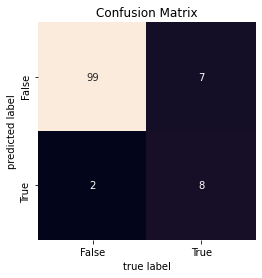

In [60]:
plotConfusionMatrix(logistic, train_df, 'poi', 'pca_reduced_10')

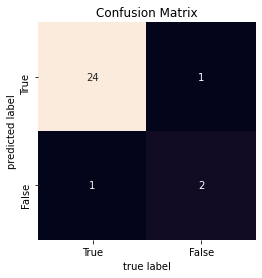

In [61]:
plotConfusionMatrix(logistic, test_df, 'poi', 'pca_reduced_10')

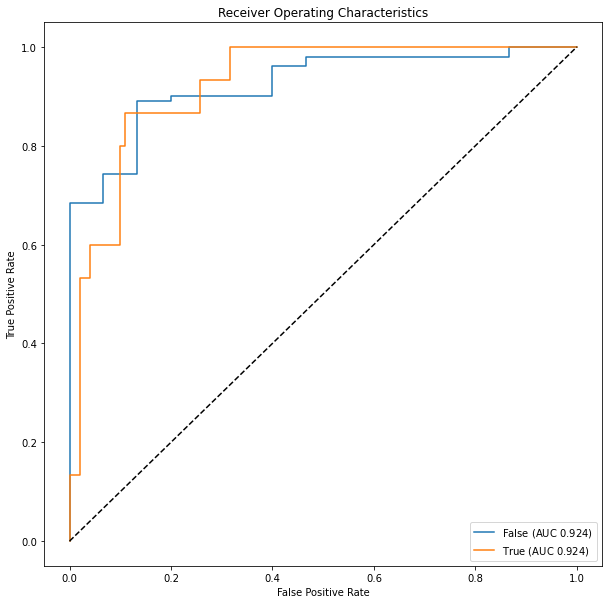

In [62]:
plotMultiROC(logistic, train_df, 'poi', 'pca_reduced_10')

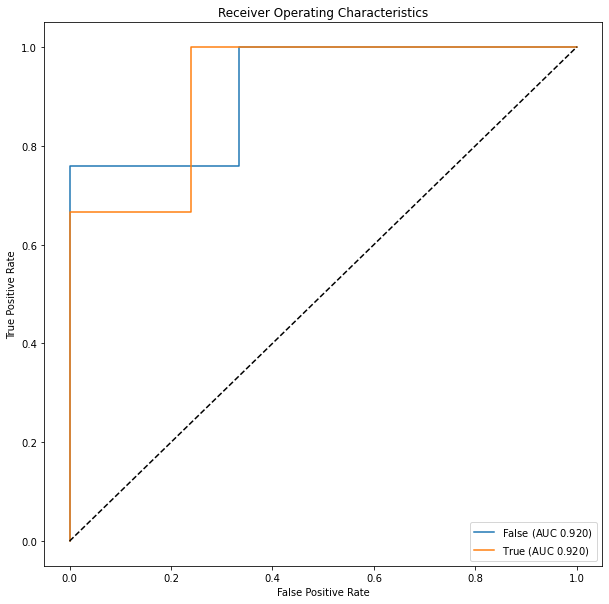

In [63]:
plotMultiROC(logistic, test_df, 'poi', 'pca_reduced_10')

### Conclusion

In [66]:
pd.read_csv('evaluation_results.csv')

,model,train_accuracy,test_accuracy,precision,recall,F1
0,Logistic Regression,0.9224,0.9286,0.6666,0.6666,0.6666
1,Naive Bayes,0.8448,0.9286,1.0000,0.5000,0.6666
2,SVM,0.9655,0.8929,0.6000,0.7500,0.6666


From the evaluaitons, I found both classifiers received high accuracy from both training and testing dataset. Compared to logistic regression model with PCA from last week, both models did not perform better than the regression model.

From the chart, we find although all three classifiers received high accuracy. Their recall, precision, and F1 values are not as high as accuracy. This can be explained by the size of the testing dataset. Because our Enron dataset is comparably small, the testing dataset contains only limited true values. Recall and precision measures the number of True Positives in the predictions, which might be affected by the dataset size. 